## Percobaan untuk Mengelompokkan Warna berdasarkan Musim
## Menggunakan DecisionTreeClassifier
## Dengan dataset ('wikipedia_color_names.csv')

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

## Data Collection + Data Preprocessing
### Load Data

In [23]:
#muat dataset colors
colors_df = pd.read_csv('wikipedia_color_names.csv')
colors_df.info()
colors_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Name                             1298 non-null   object 
 1   Hex (24 bit)                     1298 non-null   object 
 2   Red (8 bit)                      1298 non-null   int64  
 3   Green (8 bit)                    1298 non-null   int64  
 4   Blue (8 bit)                     1298 non-null   int64  
 5   Hue (degrees)                    1298 non-null   float64
 6   HSL.S (%)                        1298 non-null   float64
 7   HSL.L (%), HSV.S (%), HSV.V (%)  1298 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 81.3+ KB


,Name,Hex (24 bit),Red (8 bit),Green (8 bit),Blue (8 bit),Hue (degrees),HSL.S (%),"HSL.L (%), HSV.S (%), HSV.V (%)"
0,Absolute zero,#0048BA,0,72,186,217.0,100.0,37.0
1,Acid green,#B0BF1A,176,191,26,65.0,76.0,43.0
2,Aero,#7CB9E8,124,185,232,206.0,70.0,70.0
3,Aero blue,#C9FFE5,201,255,229,151.0,100.0,89.0
4,African violet,#B284BE,178,132,190,288.0,31.0,63.0


## Feature Engineering

Mengkategorikan warna berdasarkan nilai RGB, Hue, HSL.S, dan HSL.L ke dalam 'Season'

In [24]:
def categorize_color_by_season(row):
    """
    Mengkategorikan warna berdasarkan nilai RGB, Hue, HSL.S, dan HSL.L ke dalam musim.

    Args:
    row (pd.Series): Baris dari DataFrame yang berisi nilai RGB, Hue, HSL.S, dan HSL.L.

    Returns:
    str: Kategori musim dari warna (Spring, Summer, Autumn, Winter).
    """
    r, g, b = row['Red (8 bit)'], row['Green (8 bit)'], row['Blue (8 bit)']
    hue = row['Hue (degrees)']
    saturation = row['HSL.S (%)']
    lightness = row['HSL.L (%), HSV.S (%), HSV.V (%)']
    
    # Menghitung kecerahan (brightness)
    brightness = (r + g + b) / 3
    
    # Menghitung kehangatan (warmth)
    warmth = r - b
    
    if lightness > 70:  # Warna terang
        if warmth > 20 and saturation > 50:
            return 'Spring'
        elif saturation < 50:
            return 'Summer'
    else:  # Warna gelap
        if warmth < -20 and saturation > 50:
            return 'Winter'
        elif warmth > 20:
            return 'Autumn'
    
    return 'Uncategorized'

### Hasil Pemberian Kategori Warna Berdasarkan 'Season'

In [25]:
# Apply the function to categorize colors
colors_df['Season'] = colors_df.apply(categorize_color_by_season, axis=1)
colors_df.head(10)

,Name,Hex (24 bit),Red (8 bit),Green (8 bit),Blue (8 bit),Hue (degrees),HSL.S (%),"HSL.L (%), HSV.S (%), HSV.V (%)",Season
0,Absolute zero,#0048BA,0,72,186,217.0,100.0,37.0,Winter
1,Acid green,#B0BF1A,176,191,26,65.0,76.0,43.0,Autumn
2,Aero,#7CB9E8,124,185,232,206.0,70.0,70.0,Winter
3,Aero blue,#C9FFE5,201,255,229,151.0,100.0,89.0,Uncategorized
4,African violet,#B284BE,178,132,190,288.0,31.0,63.0,Uncategorized
5,Air Force blue (RAF),#5D8AA8,93,138,168,204.0,30.0,51.0,Uncategorized
6,Air Force blue (USAF),#00308F,0,48,143,220.0,100.0,28.0,Winter
7,Air superiority blue,#72A0C1,114,160,193,205.0,39.0,60.0,Uncategorized
8,Alabama crimson,#AF002A,175,0,42,346.0,100.0,34.0,Autumn
9,Alabaster,#F2F0E6,242,240,230,346.0,32.0,93.0,Summer


In [26]:
# Menghitung jumlah data untuk setiap kategori musim
season_counts = colors_df['Season'].value_counts()
season_counts

Season
Autumn           602
Uncategorized    310
Winter           221
Spring           115
Summer            50
Name: count, dtype: int64

### Hasil ploting warna berdasarkan kategori sudah menunjukkan pengelompokkan yang sesuai, ini berarti pola/pattern/rumus yang digunakan sudah mendekati sesuai dengan teori yang didapatkan

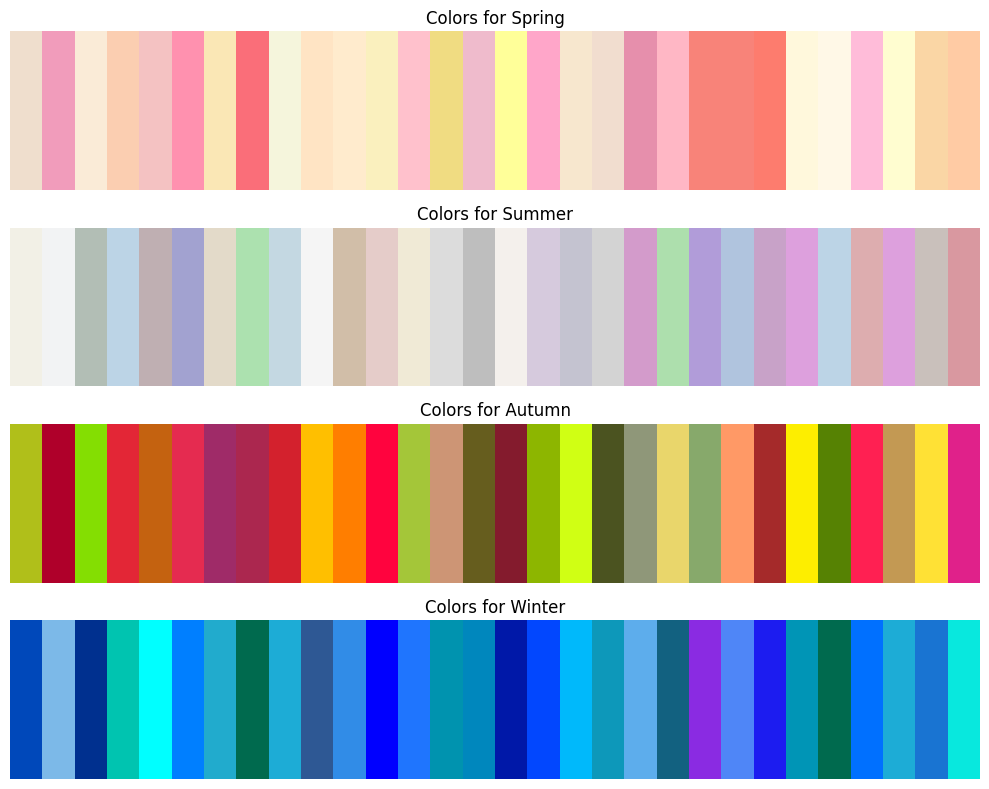

In [27]:
# Function to convert RGB values from 0-255 to 0-1 range
def rgb_to_mpl_color(rgb):
    return (rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)

# Sample colors for each season
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
colors_per_season = {season: [] for season in seasons}

# Populate colors_per_season with the actual RGB values
for season in seasons:
    season_colors = colors_df[colors_df['Season'] == season].head(30)[['Red (8 bit)', 'Green (8 bit)', 'Blue (8 bit)']].values
    colors_per_season[season] = [rgb_to_mpl_color(color) for color in season_colors]

# Plot the colors
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

for ax, season in zip(axes, seasons):
    ax.imshow([colors_per_season[season]], aspect='auto')
    ax.set_title(f'Colors for {season}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Berikut adalah link yang memuat teori pengelompokkan warna yang coba saya implementasikan pada project ini https://digitalcommons.aaru.edu.jo/faa-design/vol11/iss1/50/

### Data dari dataset menunjukkan masih ada banyak warna yang dikategorikan sebagai 'Uncategorized'

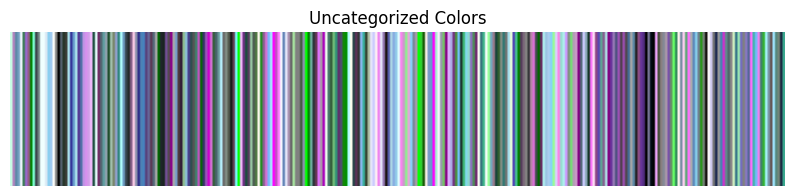

In [28]:
# Filter the data to get only the uncategorized colors
uncategorized_data = colors_df[colors_df['Season'] == 'Uncategorized']

# Function to convert RGB values from 0-255 to 0-1 range
def rgb_to_mpl_color(rgb):
    return (rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)

# Get the RGB values of the uncategorized colors
uncategorized_colors = uncategorized_data[['Red (8 bit)', 'Green (8 bit)', 'Blue (8 bit)']].values
uncategorized_colors = [rgb_to_mpl_color(color) for color in uncategorized_colors]

# Plot the uncategorized colors
plt.figure(figsize=(10, 2))
plt.imshow([uncategorized_colors], aspect='auto')
plt.title('Uncategorized Colors')
plt.axis('off')
plt.show()

Dari warna yang 'Uncategorized' ini sebenarnya memiliki kesamaan yang menurut saya pribadi memang terlihat tidak masuk ke dalam kategori warna berdasarkan pola 'Season' yang telah ditentukan, namun hal ini masih perlu dicari celahnya ada dimana, apakah perlu disesuaikan kembali rumus penentuan 'Season'-nya atau bagaimana, agar dapat mengurangi jumlah warna yang masuk ke dalam kategori 'Uncategorized' ini.

In [29]:
new_colors_df = colors_df[colors_df['Season'] != 'Uncategorized']
# Check the distribution of categories
new_colors_df.head(10)

,Name,Hex (24 bit),Red (8 bit),Green (8 bit),Blue (8 bit),Hue (degrees),HSL.S (%),"HSL.L (%), HSV.S (%), HSV.V (%)",Season
0,Absolute zero,#0048BA,0,72,186,217.0,100.0,37.0,Winter
1,Acid green,#B0BF1A,176,191,26,65.0,76.0,43.0,Autumn
2,Aero,#7CB9E8,124,185,232,206.0,70.0,70.0,Winter
6,Air Force blue (USAF),#00308F,0,48,143,220.0,100.0,28.0,Winter
8,Alabama crimson,#AF002A,175,0,42,346.0,100.0,34.0,Autumn
9,Alabaster,#F2F0E6,242,240,230,346.0,32.0,93.0,Summer
11,Alien Armpit,#84DE02,132,222,2,85.0,98.0,44.0,Autumn
12,Alizarin crimson,#E32636,227,38,54,355.0,77.0,52.0,Autumn
13,Alloy orange,#C46210,196,98,16,27.0,85.0,42.0,Autumn
14,Almond,#EFDECD,239,222,205,30.0,52.0,87.0,Spring


In [30]:
le = LabelEncoder()
new_colors_df['Season_encoded'] = le.fit_transform(new_colors_df['Season'])
new_colors_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 988 entries, 0 to 1296
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Name                             988 non-null    object 
 1   Hex (24 bit)                     988 non-null    object 
 2   Red (8 bit)                      988 non-null    int64  
 3   Green (8 bit)                    988 non-null    int64  
 4   Blue (8 bit)                     988 non-null    int64  
 5   Hue (degrees)                    988 non-null    float64
 6   HSL.S (%)                        988 non-null    float64
 7   HSL.L (%), HSV.S (%), HSV.V (%)  988 non-null    float64
 8   Season                           988 non-null    object 
 9   Season_encoded                   988 non-null    int32  
dtypes: float64(3), int32(1), int64(3), object(3)
memory usage: 81.0+ KB


C:\Users\lenovo\AppData\Local\Temp\ipykernel_21268\3302104235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_colors_df['Season_encoded'] = le.fit_transform(new_colors_df['Season'])


## Model Training

In [31]:
# Data preparation
X = new_colors_df[['Red (8 bit)', 'Green (8 bit)', 'Blue (8 bit)', 'Hue (degrees)', 'HSL.S (%)', 'HSL.L (%), HSV.S (%), HSV.V (%)']]
y = new_colors_df['Season']

In [32]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Train the model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

## Model Evaluation

In [34]:
# Make predictions
y_pred = clf.predict(X_test)

In [35]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Autumn       1.00      1.00      1.00       110
      Spring       1.00      1.00      1.00        23
      Summer       1.00      1.00      1.00        13
      Winter       1.00      1.00      1.00        52

    accuracy                           1.00       198
   macro avg       1.00      1.00      1.00       198
weighted avg       1.00      1.00      1.00       198



### Visualisasi penyebaran jumlah warna berdasarkan 'Season'

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21268\1085911565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_colors_df, x='Season',


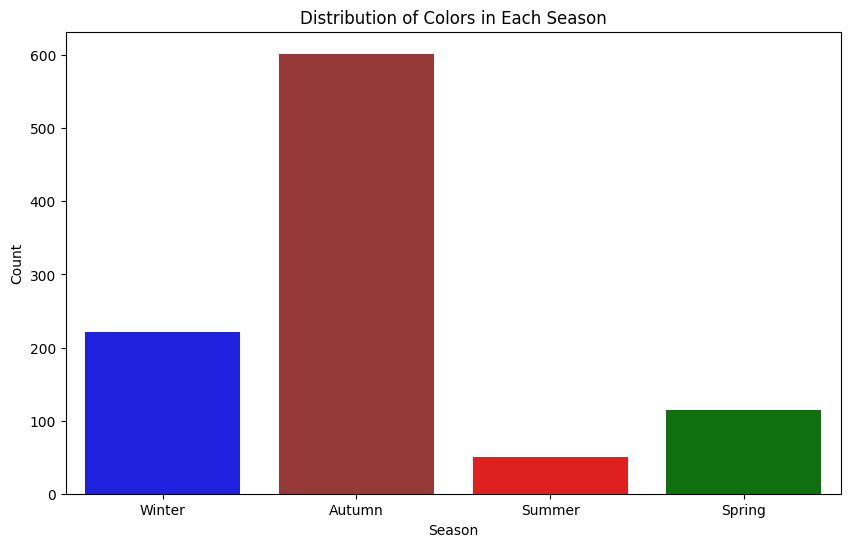

In [36]:
# Visualization Bar Chart
plt.figure(figsize=(10, 6))
sns.countplot(data=new_colors_df, x='Season', 
              palette={'Spring': 'green', 'Summer': 'red', 'Autumn': 'brown', 'Winter': 'blue'})
plt.title('Distribution of Colors in Each Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

dapat diketahui ternyata berdasarkan pola/pattern yang telah dibuat serta data warna dari dataset yang digunakan, banyak dari warna tersebut yang dikategorikan sebagai warna 'Autumn'

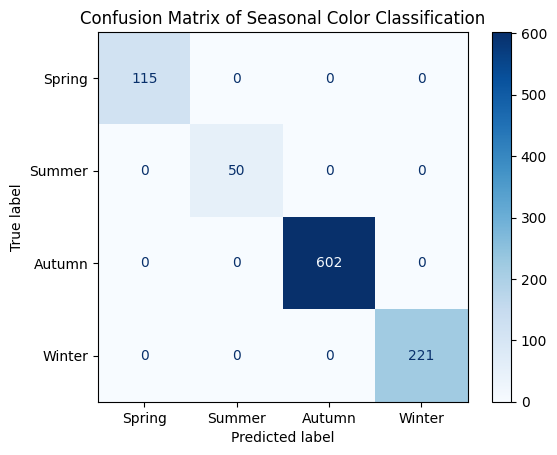

In [37]:
# Filter out Uncategorized values for better matrix visualization
filtered_data = new_colors_df[new_colors_df['Season'] != 'Uncategorized']

# Since there's no ground truth, we'll compare the predicted values to themselves
true_labels = filtered_data['Season']
predicted_labels = filtered_data['Season']

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Spring', 'Summer', 'Autumn', 'Winter'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Spring', 'Summer', 'Autumn', 'Winter'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Seasonal Color Classification')
plt.show()

## Melakukan Cross Validation

In [38]:
# Assume X and y are the features and target variable
X = new_colors_df[['Red (8 bit)', 'Green (8 bit)', 'Blue (8 bit)', 'Hue (degrees)', 'HSL.S (%)', 'HSL.L (%), HSV.S (%), HSV.V (%)']]
y = new_colors_df['Season_encoded']

In [39]:
# Use a Ridge Regression model with L2 regularization
model = Ridge(alpha=1.0)  # Adjust alpha as needed

In [40]:
# Use K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Cross-Validation Scores: [0.7796581  0.81608365 0.81149086 0.7477481  0.81507287]
Mean Cross-Validation Score: 0.7940107185909415


In [41]:
# For decision tree classifier with pruning
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)  # Adjust max_depth as needed
tree_scores = cross_val_score(tree_model, X, y, cv=kf)

print(f'Cross-Validation Scores for Decision Tree: {tree_scores}')
print(f'Mean Cross-Validation Score for Decision Tree: {tree_scores.mean()}')

Cross-Validation Scores for Decision Tree: [1.         0.98989899 0.99494949 0.98984772 0.99492386]
Mean Cross-Validation Score for Decision Tree: 0.9939240116905091


In [42]:
# Decision Tree dengan pruning (menggunakan parameter max_depth sebagai contoh)
model = DecisionTreeClassifier(max_depth=5)

cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')

print(f'Cross-Validation Scores with Pruning: {cv_scores}')
print(f'Mean Cross-Validation Score with Pruning: {cv_scores.mean()}')

Cross-Validation Scores with Pruning: [0.99620672 0.99225207 0.99615367 0.99211993 0.99223485]
Mean Cross-Validation Score with Pruning: 0.9937934468790918


## Test Model untuk Cek 'Seasonal Color' dengan input RGB

In [43]:
# Fungsi untuk konversi RGB ke HSL
def rgb_to_hsl(r, g, b):
    r /= 255
    g /= 255
    b /= 255
    max_c = max(r, g, b)
    min_c = min(r, g, b)
    l = (max_c + min_c) / 2
    if max_c == min_c:
        s = h = 0
    else:
        d = max_c - min_c
        s = d / (2 - max_c - min_c) if l > 0.5 else d / (max_c + min_c)
        if max_c == r:
            h = (g - b) / d + (6 if g < b else 0)
        elif max_c == g:
            h = (b - r) / d + 2
        elif max_c == b:
            h = (r - g) / d + 4
        h /= 6
    return int(h * 360), int(s * 100), int(l * 100)

In [44]:
# Fungsi untuk mengkategorikan warna berdasarkan RGB
def categorize_color_by_season_from_rgb(r, g, b, model):
    hue, saturation, lightness = rgb_to_hsl(r, g, b)
    
    # Buat vektor fitur
    features = np.array([[r, g, b, hue, saturation, lightness]])
    
    # Prediksi musim menggunakan model yang sudah dilatih
    season = model.predict(features)
    
    return season[0]

In [45]:
# Contoh penggunaan fungsi dengan RGB input
r = 255
g = 165
b = 0

season = categorize_color_by_season_from_rgb(r, g, b, clf)
print(f'Warna dengan RGB ({r}, {g}, {b}) termasuk dalam kategori: {season}')

Warna dengan RGB (255, 165, 0) termasuk dalam kategori: Autumn


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
